In [29]:
using DifferentialEquations
using Plots
using LaTeXStrings
using Unitful, UnitfulRecipes, UnitfulAstro
using QuadGK
using Dierckx
using PhysicalConstants.CODATA2018

## Assessing the relative importance of the terms.

The transformed Poisson equation has a term
$$
\frac{E_g}{E_t}M_0
$$
where $E_g=G m_P/\lambda_0$, $E_t=2 k T/3$, and $M_0=4\pi \lambda_0^3 n_0 m_P/3$. 

Since we have expressions for these terms (e.g. 15.21 & 15.22 in the Draine book), we can easily assess their sizes. 

In [17]:
G = NewtonianConstantOfGravitation
n0(T4; Q0p49=1.0, hnui18=1.0) = (4.54e5*T4^4.66*hnui18^(-3)/Q0p49)*u"1/cm^3"
λ0(T4; Q0p49=1.0, hnui18=1.0) = (2.47e16*Q0p49*hnui18^2/T4^2.83)*u"cm"
M0(T4; kwargs...) = 4π*λ0(T4; kwargs...)^3*n0(T4; kwargs...)*ProtonMass/3
Eg(T4; kwargs...) = G*ProtonMass*M0(T4; kwargs...)/λ0(T4; kwargs...)
Et(T4) = 2*BoltzmannConstant*T4*1e4u"K"/3

Et (generic function with 1 method)

In [22]:
T4s = LinRange(0.3, 2, 500);
EgEt = [upreferred(Eg(t)/Et(t)) for t in T4s];

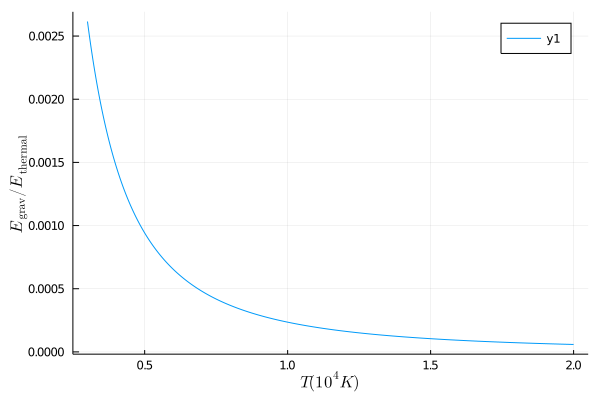

In [31]:
plot(T4s, EgEt, xlabel=L"T (10^4K)", ylabel=L"E_{\mathrm{grav}}/E_{\mathrm{thermal}}")

## Initial conditions

For the initial conditions we use the mass of the central star and say at the inner boundary this sets the gravitational potential.

$$\Psi(y_{min}) = -\frac{GM_\star m_p}{2 kT y_{min} \lambda_0}$$

For convenience it is useful to calculate some scaling relation for this. So let us put $M_\star$ in solar masses, $T=T4\times 10^4\,\mathrm{K}$, and fill in the constants:

In [41]:
  function lambda0(;T=1e4*u"K", Q0=1e49*u"1/s", hnui=18*u"eV")
    
    T4 = T/(1e4*u"K")
    Q0p49 = Q0/(1e49*u"1/s")
    res = 2.47e16*(Q0p49/T4^2.83)*(hnui/(18.0*u"eV"))^2*u"cm"
    return res
end

lambda0 (generic function with 1 method)

In [43]:
l0 = lambda0(;T=1e4*u"K")

2.47e16 cm

In [44]:
upreferred(G*UnitfulAstro.Msun*ProtonMass/(2*BoltzmannConstant*1e4u"K"*l0))

0.0032546117450724583

Thus we get a final approximation of

$$  \Psi(y_{min}) \approx 3.25461\times 10^{-3}\; T_4^{1.83}\; Q_{0,49}^{-1}\; \left(\frac{18\mathrm{eV}}{\langle h\nu\rangle_i}\right)^2 \left(\frac{M_\star}{M_\odot}\right) \frac{1}{y_{min}} $$

In [45]:
Psi_initial(ymin, Mstar; T4=1.0, Q0p49=1.0, hnui18=1.0) = 0.00325461*T4^1.83*Mstar/(ymin*Q0p49*hnui18^2)
    

Psi_initial (generic function with 1 method)

## Setting up the differential equation system

For this we want to use the delayed differential equation solver following the suggestion in https://github.com/SciML/DifferentialEquations.jl/issues/383. 

The system of equations can be written
$$
\begin{eqnarray}
\frac{du}{dy}  & = &\frac{u^2}{y^2} \eta R(y) - \gamma\frac{u}{y^2}g(\tau,\phi) - 1 \\
  \frac{d\phi}{dy} & = &-\left(\frac{y}{u}\right)^2-\gamma \frac{\phi}{u}\\
  \frac{d\tau}{dy} & =& \frac{\gamma}{u} \\
  \end{eqnarray}
  $$
where $R(y)$ is defined through
$$
R(y) = \int_0^y \frac{x^2\;dx}{u(x)} 
$$
and
$$
\eta = \frac{E_g}{E_{\mathrm{th}}}
$$

The challenge is therefore $R(y)$ which needs to be handled using the history of previous points.

In [47]:
function d2011wgravity!(dv, v, h, p, y)
    u, ϕ, τ = v
    γ, β, η, ymin = p # Ymin is indirectly a parameter of the model
    
    rint(x) = x^2/h(p, x)[1]
    Ry, err = quadgk(rint, ymin, y)
            
    dv[1] = du = u^2*η*Ry/y^2 -1 - γ*(β*exp(-τ) + ϕ)*u/y^2
    dv[2] = dϕ = -(y/u)^2 - γ * ϕ/u
    dv[3] = dτ = γ/u
end


d2011wgravity! (generic function with 1 method)

## Defining the solver

In order to solve this system we use a DDEProblem 

In [82]:
function d2011wgravitymodel(γ, β, η; u0=454, ystart=10, yend=100)
    
    starting_point = [u0, 1, 0]
    yspan = [ystart, yend]

    p = [γ, β, η, ystart]

    # The system is only defined for ϕ>=0 so we interrupt on ϕ=u[2]=0
    condition(u, y, integrator) = u[2]
    affect!(integrator) = terminate!(integrator)
    cb = ContinuousCallback(condition, affect!);
    
    # This specifies the original starting point. I think it is probably
    # necessary to rethink this  but haven't done this yet
    history(p, t) = [u0, 1, 0]
    prob = DDEProblem(d2011wgravity!, starting_point, history, yspan, p)
    
    # The choice for stepper is following https://diffeq.sciml.ai/stable/solvers/dde_solve/
    # see also https://github.com/SciML/DifferentialEquations.jl/issues/383
    sol = solve(prob, MethodOfSteps(RK4()), callback=cb);

    return sol
    
end

d2011wgravitymodel (generic function with 1 method)

In [102]:
η0 = upreferred(Eg(1)/Et(1))
sol1 = d2011wgravitymodel(10.0, 3.0, η0; u0=454);
sol2 = d2011wgravitymodel(10.0, 3.0, η0; u0=4540);
sol3 = d2011wgravitymodel(10.0, 3.0, η0; u0=45400);
# No-gravity solutions
sol1_0 = d2011wgravitymodel(10.0, 3.0, 0.0; u0=454);
sol2_0 = d2011wgravitymodel(10.0, 3.0, 0.0; u0=4540);
sol3_0 = d2011wgravitymodel(10.0, 3.0, 0.0; u0=45400);

In [84]:
tau(y, sol) = sol(y; idxs=3)
phi(y, sol) = sol(y; idxs=2)
ufunc(y, sol) = sol(y; idxs=1)


ufunc (generic function with 1 method)

In [105]:
ys = LinRange(0, 100, 500)

500-element LinRange{Float64}:
 0.0,0.200401,0.400802,0.601202,…,99.1984,99.3988,99.5992,99.7996,100.0

In [94]:
function n0(;T=1e4*u"K", Q0=1e49*u"1/s", hnui=18*u"eV")
    
    T4 = ustrip(T/(1e4*u"K"))
    Q0p49 = ustrip(Q0/(1e49*u"1/s"))
    res = 4.54e5*(T4^4.66/Q0p49)*(18.0*u"eV"/hnui)^3*u"1/cm^3"
    return res
    
end


function lambda0(;T=1e4*u"K", Q0=1e49*u"1/s", hnui=18*u"eV")
    
    T4 = T/(1e4*u"K")
    Q0p49 = Q0/(1e49*u"1/s")
    res = 2.47e16*(Q0p49/T4^2.83)*(hnui/(18.0*u"eV"))^2*u"cm"
    return res
end

lambda0 (generic function with 1 method)

In [96]:
yax = [uconvert(u"pc", y*lambda0()) for y in ys];

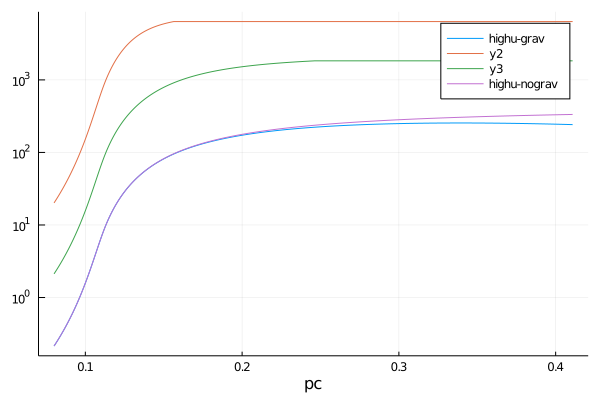

In [110]:
plot(yax, ustrip(n0()) ./ufunc(ys, sol1), yaxis=:log)
plot!(yax, ustrip(n0())./ufunc(ys, sol2), yaxis=:log)
plot(yax, ustrip(n0())./ufunc(ys, sol3), label="highu-grav", yaxis=:log)
plot!(yax, ustrip(n0())./ufunc(ys, sol1_0), yaxis=:log)
plot!(yax, ustrip(n0())./ufunc(ys, sol2_0), yaxis=:log)
plot!(yax, ustrip(n0())./ufunc(ys, sol3_0), label="highu-nograv", yaxis=:log)

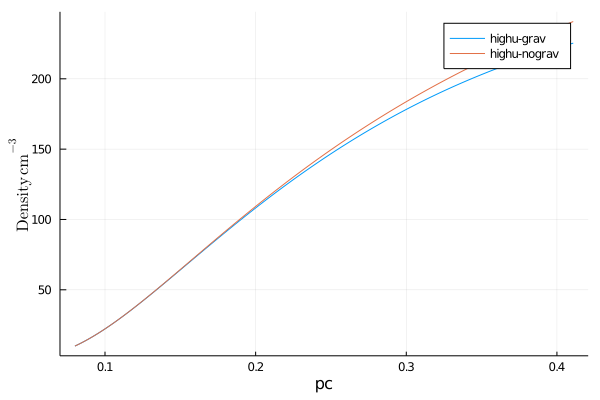

In [97]:

plot(yax, ustrip(n0())./ufunc(ys, sol3), label="highu-grav", 
    ylabel=L"\mathrm{Density}\, \mathrm{cm}^{-3}")
plot!(yax, ustrip(n0())./ufunc(ys, sol3_0), label="highu-nograv")
savefig("dustyHII-w-gravity-example.png")